In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Importar data

In [44]:
import pandas as pd
import gc
A=pd.read_csv('/content/drive/MyDrive/MIA/MIA-UC-Bimestre 02/Proyecto Aprendizaje No Supervisado/bitacora_datos_embbeding.csv',sep=';',decimal=',')
B=pd.read_csv('/content/drive/MyDrive/MIA/MIA-UC-Bimestre 02/Proyecto Aprendizaje No Supervisado/bitacora_BoW.csv', encoding='ISO-8859-1',sep=';',decimal=',')

In [47]:
C=A.merge(B[['id bitacora', 'id atencion', 'tipo profesional']],on=['id bitacora', 'id atencion'])
E=C.loc[C["tipo profesional"].isin(['medico', 'enfermera']),'embedding']

#Carga y transformacion

In [14]:
import re
import numpy as np
B=E.apply(lambda z:list(map(float,re.findall('([0-9|.|e-]+)',z))))
C=B.apply(len)
if C.max()-C.min()>0:
  B=B.apply(lambda z: z+(C.max()-len(z))*[np.nan])
D=pd.DataFrame(B.tolist(),index=B.index)
#A['id atencion']=pd.to_numeric(A['id atencion'],errors='coerce',downcast='unsigned')

#PCA

In [16]:
from sklearn.preprocessing import scale
D_scaled = scale(D)
from sklearn.decomposition import PCA
pca = PCA(n_components=D.shape[1])
pca.fit(D.corr())
x=pca.explained_variance_ratio_
z=x.cumsum()
num_car=len(z[z<=z[z>.8][0]])
pca = PCA(n_components=num_car)
D_scaled_pca=pca.fit_transform(D_scaled)
gc.collect()

0

#K-MEANS

##Metodo del Codo

cantidad de clusters optimos segun codo: 9


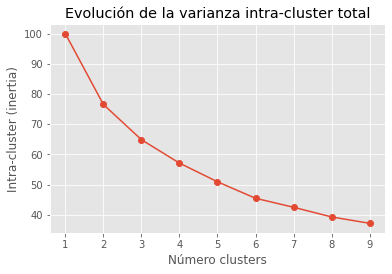

In [17]:
# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt
import matplotlib.font_manager
from matplotlib import style
style.use('ggplot') or plt.style.use('ggplot')

from sklearn.cluster import KMeans

# Método del codo para identificar el número óptimo de clusters
# ==============================================================================
def codo_kmean(X,n):
  kmeans = KMeans(n_clusters=n)
  kmeans.fit(X)
  gc.collect()
  return kmeans.inertia_
range_n_clusters = np.arange(num_car)+1
inertias=np.array(list(map(lambda n:codo_kmean(D_scaled_pca,n),range_n_clusters)))
inertias=100*inertias/inertias[0]
fig, ax = plt.subplots(1, 1, figsize=(6, 3.84))
ax.plot(range_n_clusters, inertias, marker='o')
ax.set_title("Evolución de la varianza intra-cluster total")
ax.set_xlabel('Número clusters')
ax.set_ylabel('Intra-cluster (inertia)');
#cantidadde cluster para que la perdida no sea mayor a un 10%
N_codo=range_n_clusters[inertias<20][0] if any(inertias<20) else range_n_clusters[-1]
print("cantidad de clusters optimos segun codo:",N_codo)

In [33]:
kmeans = KMeans(n_clusters=N_codo)
kmeans.fit(D_scaled_pca)
y_kmeans_codo=kmeans.labels_

from sklearn.manifold import TSNE
from sklearn.utils import shuffle
X,ind= shuffle(D_scaled_pca,np.arange(D_scaled_pca.shape[0]), n_samples=int(D_scaled_pca.shape[0]*.1))

X_embedded = TSNE(n_components=2, learning_rate='auto',init='random').fit_transform(X)

In [39]:
import plotly.express as px
df = pd.DataFrame(np.concatenate((X_embedded,y_kmeans_codo[ind].reshape(-1,1)),axis=1),columns=list(map(str,range(X_embedded.shape[1])))+['cluster'])
df['cluster']=df['cluster'].astype(int).astype(str)
fig = px.scatter(df, x="0", y="1", color="cluster",title='Grafica de clusters del embedding de palabras con PCA, K-Means y metodo del codo')
fig.show()

In [50]:
pd.concat([C.loc[C["tipo profesional"].isin(['medico', 'enfermera']),['id bitacora', 'id atencion']],pd.Series(y_kmeans_codo,index=D.index,name='cluster')],axis=1).to_csv('/content/drive/MyDrive/MIA/MIA-UC-Bimestre 02/Proyecto Aprendizaje No Supervisado/ids_cluters.csv')

###Grafica de todas las combinaciones de las dimenciones del resultado del PCA

In [ ]:
import plotly.express as px
import plotly.io as pio
def graf_html(df1,x,titulo):
  if len(x)==3:
    fig = px.scatter_3d(df1,x=x[0],y=x[1],z=x[2],color='label',title=titulo)
  elif len(x)>3:
    df1[x[3]]=(df1[x[3]]-df1[x[3]].min())
    fig = px.scatter_3d(df1,x=x[0],y=x[1],z=x[2],size=x[3],color='label',title=titulo)
  elif len(x)>4:
    df1[x[4]]=(df1[x[4]]-df1[x[4]].min())
    fig = px.scatter_3d(df1,x=x[0],y=x[1],z=x[2],color=x[3],size=x[4],symbol='label',title=titulo)
  return pio.to_html(fig)

from itertools import combinations
def combinaciones(tam,can):
  comb = list(combinations(range(tam),can))
  comstr=list(map(str,comb))
  return comb, comstr

def df_label(D,lab):
  return pd.DataFrame(np.concatenate((D,lab.reshape(-1,1)),axis=1),columns=list(range(D.shape[1]))+['label'])


gc.collect()

314

In [ ]:
kmeans = KMeans(n_clusters=N_codo)
kmeans.fit(D_scaled_pca)
y_kmeans_codo=kmeans.labels_

from IPython.core.display import display, HTML

from google.colab import widgets

#combinacion de 5 columnas para ocupar menos graficos
comb,combs = combinaciones(D_scaled_pca.shape[1],5)
t = widgets.TabBar(combs)
df=df_label(D_scaled_pca,y_kmeans_codo)
for i,x in enumerate(comb):
  with t.output_to(i, select=(i==1)):
    titulo=f"Clusterizacion por Kmeans y Codo con las dimenciones {x}"
    display(HTML(graf_html(df,x,f"Clusterizacion por Kmeans y Codo con las dimenciones {x}")))

NameError: ignored

##Metodo de Silhouette

In [ ]:
from sklearn.metrics import silhouette_score

# Método silhouette para identificar el número óptimo de clusters
# ==============================================================================
def silhouete_kmean(X,n):
  kmeans = KMeans(n_clusters=n)
  cluster_labels = kmeans.fit_predict(X)
  return silhouette_score(X, cluster_labels)
  
range_n_clusters = np.arange(1,num_car)+1
valores_medios_silhouette=np.array(list(map(lambda n:silhouete_kmean(D_scaled_pca,n),range_n_clusters)))
    
fig, ax = plt.subplots(1, 1, figsize=(6, 3.84))
ax.plot(range_n_clusters, valores_medios_silhouette, marker='o')
ax.set_title("Evolución de media de los índices silhouette")
ax.set_xlabel('Número clusters')
ax.set_ylabel('Media índices silhouette');
N_silhouette=range_n_clusters[valores_medios_silhouette.argmax()]
print("cantidad de clusters optimos segun silhouette:",N_silhouette)

###Grafica de todas las combinaciones de las dimenciones del resultado del PCA

In [ ]:
kmeans = KMeans(n_clusters=N_silhouette)
kmeans.fit(D_scaled_pca)
y_kmeans_silhouette=kmeans.labels_

from IPython.core.display import display, HTML
from google.colab import widgets


t = widgets.TabBar(combs)
df=df_label(D_scaled_pca,y_kmeans_silhouette)
for i,x in enumerate(comb):
  with t.output_to(i, select=(i==1)):
    titulo=f"Clusterizacion por Kmeans y Silhouette con las dimenciones {x}"
    display(HTML(graf_html(df,x,titulo)))

#K-MEDOID

In [ ]:
!pip install scikit-learn-extra

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# Tratamiento de datos
# ==============================================================================
import numpy as np
import pandas as pd

# Preprocesado y modelado
# ==============================================================================
from sklearn_extra.cluster import KMedoids
from sklearn.preprocessing import scale

# Método elbow para identificar el número óptimo de clusters
# ==============================================================================
def codo_kmedoids(X,n):
  kmedoids = KMedoids(n_clusters=n)
  kmedoids.fit(X)
  return kmedoids.inertia_
range_n_clusters = np.arange(num_car)+1
valores_codo_kmedoids=np.array(list(map(lambda n:codo_kmedoids(D_scaled_pca,n),range_n_clusters)))
    
range_n_clusters = np.arange(num_car)+1
valores_codo_kmedoids=np.array(list(map(lambda n:codo_kmedoids(D_scaled_pca,n),range_n_clusters)))
valores_codo_kmedoids*=100/valores_codo_kmedoids[0]
fig, ax = plt.subplots(1, 1, figsize=(6, 3.84))
ax.plot(range_n_clusters, valores_codo_kmedoids, marker='o')
ax.set_title("Evolución de la varianza intra-cluster total")
ax.set_xlabel('Número clusters')
ax.set_ylabel('Intra-cluster (inertia)');
#cantidadde cluster para que la perdida no sea mayor a un 10%
N_codo_kmedoids=range_n_clusters[valores_codo_kmedoids<20][0] if any(valores_codo_kmedoids<20) else range_n_clusters[-1]
print("cantidad de clusters optimos segun codo:",N_codo_kmedoids)

###Grafica de todas las combinaciones de las dimenciones del resultado del PCA

In [ ]:
kmedoids = KMedoids(n_clusters=N_codo_kmedoids)
kmedoids.fit(D_scaled_pca)
y_kmedoids_codo=kmedoids.labels_

from IPython.core.display import display, HTML
from google.colab import widgets

t = widgets.TabBar(combs)
df=df_label(D_scaled_pca,y_kmedoids_codo)
for i,x in enumerate(comb):
  with t.output_to(i, select=(i==1)):
    titulo=f"Clusterizacion por Kmedoids y codo con las dimenciones {x}"
    display(HTML(graf_html(df,x,titulo)))

##Metodo de Silhouette

In [ ]:
from sklearn.metrics import silhouette_score

# Método silhouette para identificar el número óptimo de clusters
# ==============================================================================
def silhouete_kmedoids(X,n):
  kmedoids = KMedoids(n_clusters=n_clusters=n)
  cluster_labels =kmedoids.fit_predict(X)
  return silhouette_score(X, cluster_labels)
  
range_n_clusters = np.arange(1,num_car)+1
valores_silhouete_kmedoids=np.array(list(map(lambda n:silhouete_kmedoids(D_scaled_pca,n),range_n_clusters)))
    
fig, ax = plt.subplots(1, 1, figsize=(6, 3.84))
ax.plot(range_n_clusters,valores_silhouete_kmedoids, marker='o')
ax.set_title("Evolución de media de los índices silhouette")
ax.set_xlabel('Número clusters')
ax.set_ylabel('Media índices silhouette');
N_silhouete_kmedoids=range_n_clusters[valores_silhouete_kmedoids.argmax()]
print("cantidad de clusters optimos segun silhouette:",N_silhouete_kmedoids)

###Grafica de todas las combinaciones de las dimenciones del resultado del PCA

In [ ]:
kmedoids = KMedoids(n_clusters=N_silhouete_kmedoids)
kmedoids.fit(D_scaled_pca)
y_kmedoids_silhouette=kmedoids.labels_

from IPython.core.display import display, HTML
from google.colab import widgets


t = widgets.TabBar(combs)
df=df_label(D_scaled_pca,y_kmedoids_silhouette)
for i,x in enumerate(comb):
  with t.output_to(i, select=False):
    titulo="Clusterizacion por Kmedoids y Silhouette con las dimenciones {x}"
    display(HTML(graf_html(df,x,titulo)))

#Meanshift

In [ ]:
from sklearn.cluster import MeanShift, estimate_bandwidth

# The following bandwidth can be automatically detected using
bandwidth = estimate_bandwidth(D_scaled_pca, quantile=0.2, n_samples=500)

ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
ms.fit(D_scaled_pca)
labels = ms.labels_
cluster_centers = ms.cluster_centers_

###Grafica de todas las combinaciones de las dimenciones del resultado del PCA

In [ ]:
from IPython.core.display import display, HTML
from google.colab import widgets

t = widgets.TabBar(combs)
df=df_label(D_scaled_pca,labels)
for i,x in enumerate(comb):
  with t.output_to(i, select=False):
    titulo="Clusterizacion por Kmedoids y Silhouette con las dimenciones {x}"
    display(HTML(graf_html(df,x,titulo)))